# Forberedelsen af data

In [1]:
#Libriaries & Models
import matplotlib
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Layer, LSTM, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.losses import MeanSquaredError


from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

from scipy.spatial.distance import cdist
from scipy.linalg import pinv
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

import os
import pickle

import importlib
import src
importlib.reload(src)

2024-12-20 15:27:28.812688: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Python random seed set.
NumPy random seed set.
TensorFlow (Keras) random seed set.
Python random seed set.
NumPy random seed set.
TensorFlow (Keras) random seed set.


<module 'src' from '/Users/hugojohnson/Desktop/Deep Learning/02456-deep-learning-project/src/__init__.py'>

Access the datasets

In [2]:
dataframes = src.dataset.load_dataframes()

Loaded from pickle


Data handling

In [3]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = src.dataset.load_split_data(shuffle=False)

# Konverter til 3D-format for LSTM (samples, timesteps, features)
# Her antages en enkelt timestep, men du kan øge det, hvis du vil have flere tidssteg
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Loaded from pickle


# LSTM - RBF Model





In [4]:
num_centers = 30
sigma = 1.0
lstm_nodes = 5

# Brugerdefineret RBF-lag i Keras
class RBFLayer(Layer):
    def __init__(self, num_centers, sigma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.num_centers = num_centers
        self.sigma = sigma

    def build(self, input_shape):
        # Generér centre tilfældigt ved initialisering
        self.centers = self.add_weight(
            shape=(self.num_centers, input_shape[-1]),
            initializer="random_normal",
            trainable=True,
            name="centers"
        )

    def call(self, inputs):
        # Beregn euklidisk afstand fra input til centre
        inputs_expanded = tf.expand_dims(inputs, 1)  # (batch, 1, features)
        centers_expanded = tf.expand_dims(self.centers, 0)  # (1, num_centers, features)

        # Beregn euklidisk afstand
        distances = tf.reduce_sum(tf.square(inputs_expanded - centers_expanded), axis=-1)
        return tf.exp(-distances / (2 * tf.square(self.sigma)))

model = Sequential([
    RBFLayer(num_centers=num_centers, sigma=sigma, input_shape=(1, X_train.shape[-1])),
    LSTM(lstm_nodes, activation='tanh', return_sequences=False),  # LSTM lag
    Dense(y_train.shape[1])  # Output lag for Mz1, Mz2, Mz3
])

model.compile(optimizer='adam', loss='mse')

/var/folders/_4/qbt6rn_s3_7gh2mhy42959c80000gn/T/ipykernel_17038/1143035431.py:8: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


# Training the model

In [6]:
batchsize = 32
epochs = 30

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batchsize, validation_split=0.2, verbose=1)

# Forudsig output for testdata
y_pred = model.predict(X_test)


# Omvend normalisering af y_pred og y_test
# y_pred = scaler_y.inverse_transform(y_pred)
# y_test = scaler_y.inverse_transform(y_test)

# Beregn MSE
mse = tf.keras.losses.MeanSquaredError()
mse_value = mse(y_test, y_pred).numpy()
print("Mean Squared Error of test data:", mse_value)

# mse = MeanSquaredError(y_test, y_pred)
# print("Mean Squared Error på testdata:", mse)

Epoch 1/30
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 2/30
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 3/30
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 4/30
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 5/30
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 6/30
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/30
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 8/30
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 9/30
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 10/30
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 11/30
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 12/30
6400/6400 ━━━━━━━━

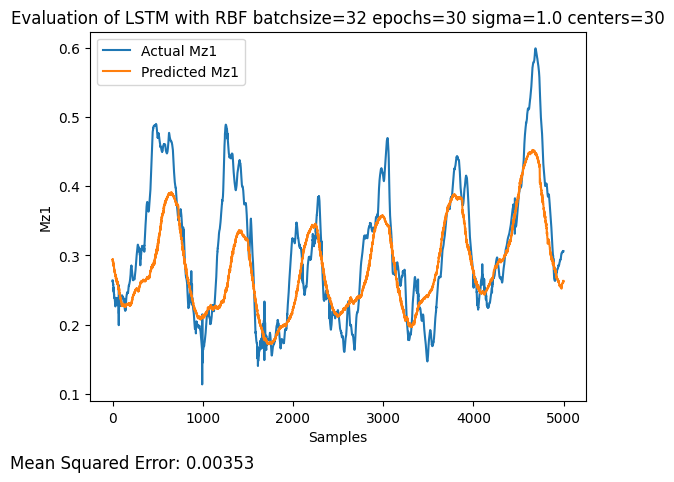

In [7]:
src.plots.evaluate_predictions(y_pred[:, 0][:5000], y_test[:, 0][:5000], mse(y_test, y_pred).numpy(), name=f"LSTM with RBF batchsize={batchsize} epochs={epochs} sigma={sigma} centers={num_centers}")

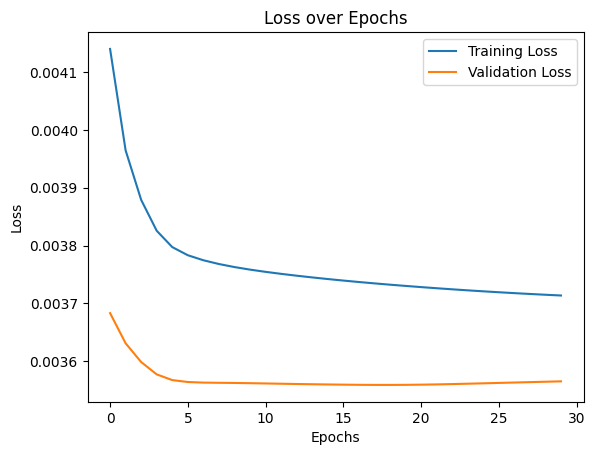

In [8]:
# Extract loss values
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Convert the tensor to a NumPy array
numpy_array = y_pred
# Convert the NumPy array to a DataFrame
df = pd.DataFrame(numpy_array)
# Save the DataFrame to a CSV file
df.to_csv('tensor_data.csv', index=False)